# MIA with GAN-Leaks and Monte Carlo Membership
The performance of the distance based attack models is influenced by the amount of the synthetic data used as input of the model.  In this notebook, we explore the relationship between the effaciency of the model and the number of generated samples used.

We assume that the well-trained generator is available. 

# 1 Initiation

In [1]:
# Standard library
import sys

sys.path.append("../..")

import tempfile

# 3rd party packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Local packages
from generators.mst_generator import MSTGenerator
from metrics.privacy.membership import GANLeaks, MCMembership
from mia_ensemble.src import config
from mia_ensemble.src.attack import Ensemble
from mia_ensemble.src.data import real_data

# 2 Data and generator

In [2]:
generator = "mst"
path = config.OUTPUT_PATH / generator

## 2.1 Load the real data

In [4]:
df_real_train = pd.read_csv(path / "data" / "real" / "real_train.csv")
df_real_control_val = pd.read_csv(path / "data" / "real" / "real_control_val.csv")
df_real_control_test = pd.read_csv(path / "data" / "real" / "real_control_test.csv")

In [5]:
# Build test set

cat_cols = [
    col for col in df_real_train.columns if col not in config.metadata["continuous"]
]

_, _, df_test, y_test = Ensemble.prepare_data(
    df_real_train=df_real_train,
    df_real_control_val=df_real_control_val,
    df_real_control_test=df_real_control_test,
    cat_cols=cat_cols,
    seed=config.seed,
)

## 2.2 Load trained generator

In [12]:
gen = MSTGenerator(
    df=df_real_train,
    metadata=config.metadata,
    random_state=config.seed,
    generator_filepath=path
    / "generator"
    / "1st_generation"
    / "2024-04-24_MST.pkl",  # to load an existing generator
    epsilon=1e5,
    delta=0.9999,
)

gen.preprocess()

# 3 Membership inference attack

In [9]:
n_synth_sample = np.logspace(
    start=np.log10(int(0.01 * len(df_real_train))),
    stop=np.log10(10 * len(df_real_train)),
    num=20,
    dtype=np.int32,
)

In [23]:
n_synth_sample

array([   103,    149,    215,    309,    445,    640,    921,   1326,
         1907,   2744,   3948,   5679,   8170,  11754,  16910,  24326,
        34995,  50344,  72425, 104189], dtype=int32)

In [13]:
iteration = 10
ganleaks_top1_precision = {}
ganleaks_top50_precision = {}
mc_top1_precision = {}
mc_top50_precision = {}

temp_dir = tempfile.TemporaryDirectory()

for n in n_synth_sample:
    ganleaks_top1_precision[f"{n}samples"] = []
    ganleaks_top50_precision[f"{n}samples"] = []
    mc_top1_precision[f"{n}samples"] = []
    mc_top50_precision[f"{n}samples"] = []

    for i in range(iteration):
        df_synth = gen.sample(
            save_path=temp_dir.name,  # the path should exist
            num_samples=n,
        )

        ganleaks = GANLeaks()
        precision_top1_ganleaks, precision_top50_ganleaks, _, _, _ = ganleaks.eval(
            df_test=df_test,
            y_test=y_test,
            df_synth=df_synth,
            cat_cols=config.metadata["categorical"],
        )

        ganleaks_top1_precision[f"{n}samples"].append(precision_top1_ganleaks)
        ganleaks_top50_precision[f"{n}samples"].append(precision_top50_ganleaks)

        mcmembership = MCMembership()
        (
            precision_top1_mcmembership,
            precision_top50_mcmembership,
            _,
        ) = mcmembership.eval(
            df_test=df_test,
            y_test=y_test,
            df_synth=df_synth,
            cat_cols=config.metadata["categorical"],
        )
        mc_top1_precision[f"{n}samples"].append(precision_top1_mcmembership)
        mc_top50_precision[f"{n}samples"].append(precision_top50_mcmembership)


temp_dir.cleanup()

# 4 Visualize the result

In [15]:
# Convert results to pandas DataFrame
df_ganleaks_top1 = pd.DataFrame(ganleaks_top1_precision)
df_ganleaks_top50 = pd.DataFrame(ganleaks_top50_precision)

df_mc_top1 = pd.DataFrame(mc_top1_precision)
df_mc_top50 = pd.DataFrame(mc_top50_precision)

# Append mean and std
df_ganleaks_top1.loc["mean"] = df_ganleaks_top1.mean(axis=0)
df_ganleaks_top1.loc["std"] = df_ganleaks_top1.std(axis=0)
df_ganleaks_top50.loc["mean"] = df_ganleaks_top50.mean(axis=0)
df_ganleaks_top50.loc["std"] = df_ganleaks_top50.std(axis=0)

df_mc_top1.loc["mean"] = df_mc_top1.mean(axis=0)
df_mc_top1.loc["std"] = df_mc_top1.std(axis=0)
df_mc_top50.loc["mean"] = df_mc_top50.mean(axis=0)
df_mc_top50.loc["std"] = df_mc_top50.std(axis=0)

In [17]:
# Save the result

df_ganleaks_top1.to_csv(
    f"{generator}_ganleaks_top1.csv",
    index=False,
)
df_ganleaks_top50.to_csv(
    f"{generator}_ganleaks_top50.csv",
    index=False,
)
df_mc_top1.to_csv(
    f"{generator}_mc_top1.csv",
    index=False,
)
df_mc_top50.to_csv(
    f"{generator}_mc_top50.csv",
    index=False,
)

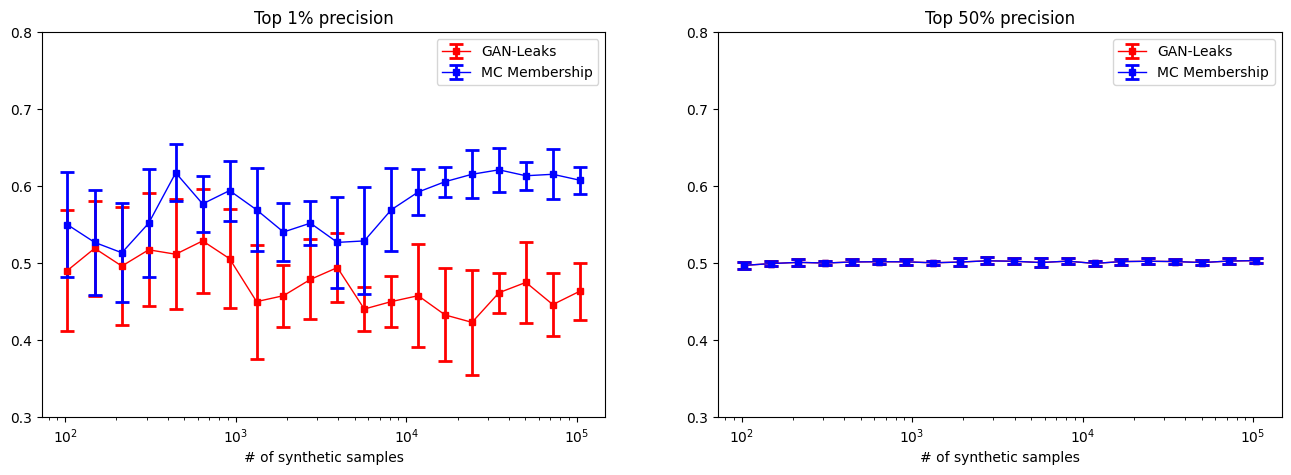

In [28]:
# Plot

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].errorbar(
    x=n_synth_sample,
    y=df_ganleaks_top1.loc["mean"],
    yerr=df_ganleaks_top1.loc["std"],
    color="red",
    linewidth=1,
    marker="s",
    mfc="red",
    mec="red",
    ms=5,
    ecolor="red",
    elinewidth=2,
    capsize=5,
    capthick=2,
    label="GAN-Leaks",
)
axs[0].errorbar(
    x=n_synth_sample,
    y=df_mc_top1.loc["mean"],
    yerr=df_mc_top1.loc["std"],
    color="blue",
    linewidth=1,
    marker="s",
    mfc="blue",
    mec="blue",
    ms=5,
    ecolor="blue",
    elinewidth=2,
    capsize=5,
    capthick=2,
    label="MC Membership",
)
axs[0].set_xscale("log")
axs[0].set_xlabel("# of synthetic samples")
axs[0].set(ylim=[0.3, 0.8])
axs[0].legend()
axs[0].set_title("Top 1% precision")

axs[1].errorbar(
    x=n_synth_sample,
    y=df_ganleaks_top50.loc["mean"],
    yerr=df_ganleaks_top50.loc["std"],
    color="red",
    linewidth=1,
    marker="s",
    mfc="red",
    mec="red",
    ms=5,
    ecolor="red",
    elinewidth=2,
    capsize=5,
    capthick=2,
    label="GAN-Leaks",
)
axs[1].errorbar(
    x=n_synth_sample,
    y=df_mc_top50.loc["mean"],
    yerr=df_mc_top50.loc["std"],
    color="blue",
    linewidth=1,
    marker="s",
    mfc="blue",
    mec="blue",
    ms=5,
    ecolor="blue",
    elinewidth=2,
    capsize=5,
    capthick=2,
    label="MC Membership",
)
axs[1].set_xscale("log")
axs[1].set_xlabel("# of synthetic samples")
axs[1].set(ylim=[0.3, 0.8])
axs[1].legend()
axs[1].set_title("Top 50% precision")
plt.savefig(f"{generator}_ganleaks_mc_result.png", dpi=1200)
plt.show()